## Proyecto 3 - SDS
### Sara Zavala

In [1]:
##Ataque de extracción 

In [2]:
import pprint
import numpy as np
import pandas as pd
from sklearn import *
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.path import Path
from sklearn.utils import class_weight
from matplotlib.patches import PathPatch
from keras.models import Sequential, Model
from sklearn.datasets import make_classification
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer
from sklearn.model_selection import train_test_split
from art.attacks.evasion import BasicIterativeMethod
from art.defences.postprocessor import ReverseSigmoid
from keras.preprocessing.image import ImageDataGenerator
from art.estimators.classification import KerasClassifier
from art.attacks.extraction import CopycatCNN, KnockoffNets
from art.estimators.classification import TensorFlowV2Classifier
from keras.layers import Conv2D, MaxPooling2D, InputLayer, Reshape
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.python.framework.ops import disable_eager_execution

In [3]:
tf.compat.v1.disable_eager_execution()

In [4]:
path = ("malimg_paper_dataset_imgs")

In [5]:
path_images = ImageDataGenerator().flow_from_directory(directory=path, target_size=(128,128), batch_size=10000)

Found 9339 images belonging to 25 classes.


In [6]:
path_images.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [7]:
data = path_images.class_indices
data2 = list(data.values())
print(len(data2)-1)

24


In [8]:
# x, y = next(batches)
images, marks = next(path_images)

In [9]:
images.shape

(9339, 128, 128, 3)

In [10]:
images.size

459030528

In [11]:
marks.size

233475

In [12]:
print('Images size --> ', images.itemsize)
print('Marks --> ',marks.itemsize)

Images size -->  4
Marks -->  4


In [13]:
images

array([[[[143., 143., 143.],
         [173., 173., 173.],
         [126., 126., 126.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[ 78.,  78.,  78.],
         [102., 102., 102.],
         [225., 225., 225.],
         ...,
         [245., 245., 245.],
         [158., 158., 158.],
         [ 86.,  86.,  86.]],

        ...,

        [[ 14.,  14.,  14.],
         [ 97.,  97.,  97.],
         [ 66.,  66.,  66.],
         ...,
         [ 81.,  81.,  81.],
         [ 91.,  91.,  91.],
         [ 16.,  16.,  16.]],

        [[212., 212., 212.],
         [114., 114., 114.],
         [248., 248., 248.],
         ...,
         [194., 194., 194.],
         [137., 137., 137.],
         [154., 154., 154.]],

        [[ 67.,  67.,  67.],
       

In [14]:
marks

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [15]:
## Entrenamiento y prediccion

In [16]:
X_train, X_test0, y_train, y_test0 = train_test_split(images, marks, test_size = 0.2)

In [ ]:
## TRAIN

In [17]:
X_train.shape

(7471, 128, 128, 3)

In [18]:
y_train.shape

(7471, 25)

In [19]:
X_train.size

367214592

In [20]:
y_train.size

186775

In [21]:
## TEST

In [22]:
X_test0.shape

(1868, 128, 128, 3)

In [23]:
y_test0.shape

(1868, 25)

In [24]:
X_test0.size

91815936

In [25]:
y_test0.size

46700

## Modelo Original - Red

In [26]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, (5, 5), input_shape=(128, 128, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(25, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
# Compile
# https://faroit.com/keras-docs/2.1.3/models/sequential/
model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 460800)            0

In [29]:
model.layers

In [30]:
print(model.optimizer)

In [31]:
print(model.metrics)

In [35]:
# Comprobacion sobre data
op = model.evaluate(X_test0, y_test0)
print("Exactitud -->", op[0])

Exactitud --> 46.46266961761409


In [36]:
model.fit(X_train, y_train, batch_size=10, validation_data=(X_test0, y_test0), epochs=5)

Train on 7471 samples, validate on 1868 samples
Epoch 1/5
7471/7471 [==============================] - 231s 31ms/sample - loss: 0.3872 - accuracy: 0.8999 - val_loss: 0.7327 - val_accuracy: 0.7093
Epoch 2/5
7471/7471 [==============================] - 226s 30ms/sample - loss: 0.0793 - accuracy: 0.9716 - val_loss: 0.0819 - val_accuracy: 0.9673
Epoch 3/5
7471/7471 [==============================] - 236s 32ms/sample - loss: 0.0257 - accuracy: 0.9916 - val_loss: 0.0727 - val_accuracy: 0.9781
Epoch 4/5
7471/7471 [==============================] - 269s 36ms/sample - loss: 0.0072 - accuracy: 0.9984 - val_loss: 0.0721 - val_accuracy: 0.9797
Epoch 5/5
7471/7471 [==============================] - 274s 37ms/sample - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.0721 - val_accuracy: 0.9818


In [37]:
## Modelo Robado

In [38]:
modelR = Sequential()
modelR.add(keras.layers.Rescaling(1./255, input_shape=(128, 128, 3)))
modelR.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
modelR.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
modelR.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
modelR.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
modelR.add(keras.layers.Flatten())
modelR.add(keras.layers.Dense(1024, activation='relu'))
modelR.add(keras.layers.Dense(25, activation='softmax'))

In [39]:
    modelR.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [40]:
modelR.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)             

In [41]:
modelR.layers

In [42]:
print(modelR.optimizer)

In [43]:
print(modelR.metrics)

In [44]:
# Comprobacion sobre data
op = modelR.evaluate(X_test0, y_test0)
print("Exactitud -->", op[1])

Exactitud --> 0.020342613


In [46]:
modelR.fit(X_train, y_train, batch_size=10, validation_data=(X_test0, y_test0), epochs=5)

Train on 7471 samples, validate on 1868 samples
Epoch 1/5
7471/7471 [==============================] - 247s 33ms/sample - loss: 0.3037 - accuracy: 0.9145 - val_loss: 0.1971 - val_accuracy: 0.9411
Epoch 2/5
7471/7471 [==============================] - 261s 35ms/sample - loss: 0.1113 - accuracy: 0.9673 - val_loss: 0.1704 - val_accuracy: 0.9475
Epoch 3/5
7471/7471 [==============================] - 271s 36ms/sample - loss: 0.0834 - accuracy: 0.9747 - val_loss: 0.1771 - val_accuracy: 0.9577
Epoch 4/5
7471/7471 [==============================] - 270s 36ms/sample - loss: 0.0515 - accuracy: 0.9845 - val_loss: 0.1606 - val_accuracy: 0.9593
Epoch 5/5
7471/7471 [==============================] - 285s 38ms/sample - loss: 0.0392 - accuracy: 0.9884 - val_loss: 0.1224 - val_accuracy: 0.9684


In [47]:
print(modelR.optimizer)

In [48]:
print(modelR.metrics)

In [49]:
# Comprobacion sobre conjunto de prueba
op = modelR.evaluate(X_test0, y_test0)
print("Exactitud -->", op[1])

Exactitud --> 0.96841544


In [50]:
#tf.compat.v1.disable_eager_execution()

In [51]:
model_class = KerasClassifier(model, clip_values=(0, 1), use_logits=False)

In [52]:
modelR_class = KerasClassifier(modelR, clip_values=(0, 1), use_logits=False)

In [53]:
cantidad_de_ataques = BasicIterativeMethod(modelR_class, eps=60, eps_step=2, max_iter=40)

In [54]:
modelR_train = AdversarialTrainer(modelR_class, cantidad_de_ataques, ratio=1.0)

In [55]:
#Necesito compilarlo antes
#TARDA 500 ANIOS ESPERAR AL FINAL
#modelR_train.fit(X_train, y_train, nb_epochs=2, batch_size=50)

In [56]:
#data original
predict_xtest0 = np.argmax(model_class.predict(X_test0), axis=1)
predict_xtest1 = np.sum(predict_xtest0 == np.argmax(y_test0, axis=1))

In [64]:
predict_xtest0

array([22, 17,  2, ...,  7,  2,  2], dtype=int64)

In [65]:
predict_xtest1

1834

In [57]:
test_attack = FastGradientMethod(model_class, eps=100)

In [58]:
result = test_attack.generate(X_test0)

In [59]:
test_result = np.argmax(model_class.predict(result), axis=1)

In [60]:
result0_test = np.sum(test_result == np.argmax(y_test0, axis=1))

In [61]:
test_attack

In [62]:
result

array([[[[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  1.,   0.,   1.],
         [  1.,   0.,   1.],
         [  0.,   1.,   1.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   1.,   1.],
         [  1.,   1.,   0.],
         [  0.,   0.,   0.]],

        [[  1.,   1.,   1.],
         [  1.,   1.,   0.],
         [  1.,   1.,   1.],
         ...,
         [  0.,   1.,   1.],
         [  0.,   0.,   1.],
         [  1.,   0.,   1.]],

        ...,

        [[  1.,   1.,   1.],
         [  1.,   1.,   1.],
         [  1.,   0.,   0.],
         ...,
         [155., 155., 155.],
         [  1.,   0.,   1.],
         [ 64.,  64.,  64.]],

        [[  1.,   1.,   1.],
         [  0.,   0.,   1.],
         [  0.,   0.,   1.],
         ...,
         [  0.,   1.,   0.],
         [  1.,   1.,   1.],
         [  0.,   0.,   0.]],

        [[  1.,   1.,   0.],
       

In [63]:
result0_test

654

In [ ]:
print("Clasificados correctamente: {}".format(test_result))
print("Clasificados incorrectamente: {}".format(len(X_test0)-result0_test))
print("Porcentaje: {}".format(result0_test/len(X_test0)))

### Modelo robado del modelo original

In [68]:
attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=model_class,
                                              batch_size_fit=128,
                                              batch_size_query=128,
                                              nb_epochs=5,
                                              nb_stolen=2500,
                                              use_probability=True),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=model_class,
                                              batch_size_fit=128,
                                              batch_size_query=128,
                                              nb_epochs=5,
                                              nb_stolen=2500,
                                              use_probability=True)
                   }


In [73]:
results = []
for len_steal in [250, 500, 1000,1500,1800]:
    indices = np.random.permutation(len(X_test0))
    x_steal = X_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = X_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = model
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, "--> ", acc)
        results.append((name, len_steal, acc))

Train on 250 samples
Epoch 1/5
250/250 [==============================] - 5s 20ms/sample - loss: 0.0422 - accuracy: 1.0000
Epoch 2/5
250/250 [==============================] - 5s 21ms/sample - loss: 0.0418 - accuracy: 1.0000
Epoch 3/5
250/250 [==============================] - 5s 21ms/sample - loss: 0.0418 - accuracy: 1.0000
Epoch 4/5
250/250 [==============================] - 5s 21ms/sample - loss: 0.0424 - accuracy: 0.9920
Epoch 5/5
250/250 [==============================] - 5s 22ms/sample - loss: 0.0420 - accuracy: 1.0000
Probabilistic CopycatCNN -->  0.9789864
Probabilistic KnockoffNets -->  0.9789864
Train on 500 samples
Epoch 1/5
500/500 [==============================] - 11s 22ms/sample - loss: 0.0474 - accuracy: 0.9960
Epoch 2/5
500/500 [==============================] - 11s 22ms/sample - loss: 0.0480 - accuracy: 0.9920
Epoch 3/5
500/500 [==============================] - 11s 22ms/sample - loss: 0.0479 - accuracy: 0.9940
Epoch 4/5
500/500 [==============================] - 13s 

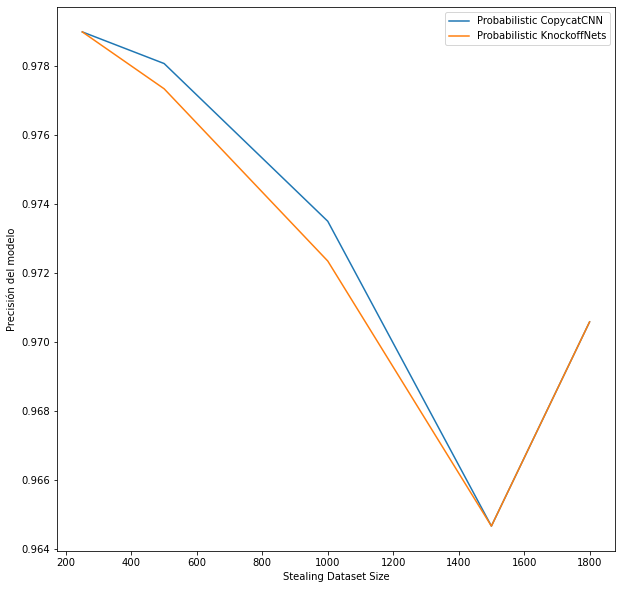

In [90]:
df = pd.DataFrame(
    results, 
    columns=('Method Name', 
             'Stealing Dataset Size', 
             'Accuracy'))

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("Tamaño")
ax.set_ylabel("Precisión del modelo")
for name, group in df.groupby("Method Name"):group.plot(1, 2, ax=ax, label=name)
plt.show()

## Modelo Protegido

In [75]:
post_processor = ReverseSigmoid(beta = 1.0, gamma = 0.2)

In [76]:
protect_class = KerasClassifier(model, clip_values=(0, 1), use_logits=False, postprocessing_defences=post_processor)

In [78]:
modelP = Sequential([InputLayer([128, 128, 3]), Reshape([128, 128, 3]), model])

In [79]:
modelP.compile('SGD', 'categorical_crossentropy', ['accuracy'])

In [80]:
modelP_class = KerasClassifier(modelP, clip_values=(0, 1), use_logits=False, postprocessing_defences=post_processor)

In [81]:
attack_catalogue = {
                    "Probabilistic CopycatCNN Protected": CopycatCNN(classifier=protect_class,
                                              batch_size_fit=128,
                                              batch_size_query=128,
                                              nb_epochs=5,
                                              nb_stolen=2500,
                                              use_probability=True),
                    "Argmax CopycatCNN Protected": CopycatCNN(classifier=protect_class,
                                              batch_size_fit=128,
                                              batch_size_query=128,
                                              nb_epochs=5,
                                              nb_stolen=2500,
                                              use_probability=False),
                    "Probabilistic KnockoffNets Protected": KnockoffNets(classifier=protect_class,
                                              batch_size_fit=128,
                                              batch_size_query=128,
                                              nb_epochs=5,
                                              nb_stolen=2500,
                                              use_probability=True),
                    "Argmax KnockoffNets Protected": KnockoffNets(classifier=protect_class,
                                              batch_size_fit=128,
                                              batch_size_query=128,
                                              nb_epochs=5,
                                              nb_stolen=2500,
                                              use_probability=False),
}

In [82]:
resultsPr = []
for len_steal in [250, 500, 1000, 1500, 1800]:
    indices = np.random.permutation(len(X_test0))
    x_steal = X_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = X_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = modelR
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        if name=="FunctionallyEquivalentExtraction":classifier_stolen = attack.extract(np.reshape(x_steal, [len(x_steal), -1]), y_steal, thieved_classifier=classifier_stolen)
        else:classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, "-->", acc)
        resultsPr.append((name, len_steal, acc))

C:\ProgramData\Anaconda3\lib\site-packages\art\defences\postprocessor\reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)


Train on 250 samples
Epoch 1/5
250/250 [==============================] - 3s 12ms/sample - loss: 19.3254 - accuracy: 0.9480
Epoch 2/5
250/250 [==============================] - 3s 10ms/sample - loss: 4.8412 - accuracy: 0.7920
Epoch 3/5
250/250 [==============================] - 2s 10ms/sample - loss: 3.3172 - accuracy: 0.0920
Epoch 4/5
250/250 [==============================] - 2s 10ms/sample - loss: 3.2458 - accuracy: 0.0280
Epoch 5/5
250/250 [==============================] - 3s 10ms/sample - loss: 3.2289 - accuracy: 0.0520
Probabilistic CopycatCNN Protected --> 0.008652657
Train on 250 samples
Epoch 1/5
250/250 [==============================] - 2s 9ms/sample - loss: 3.1419 - accuracy: 0.2160
Epoch 2/5
250/250 [==============================] - 2s 9ms/sample - loss: 2.3806 - accuracy: 0.2760
Epoch 3/5
250/250 [==============================] - 2s 9ms/sample - loss: 2.2298 - accuracy: 0.2400
Epoch 4/5
250/250 [==============================] - 2s 9ms/sample - loss: 2.1754 - accuracy:

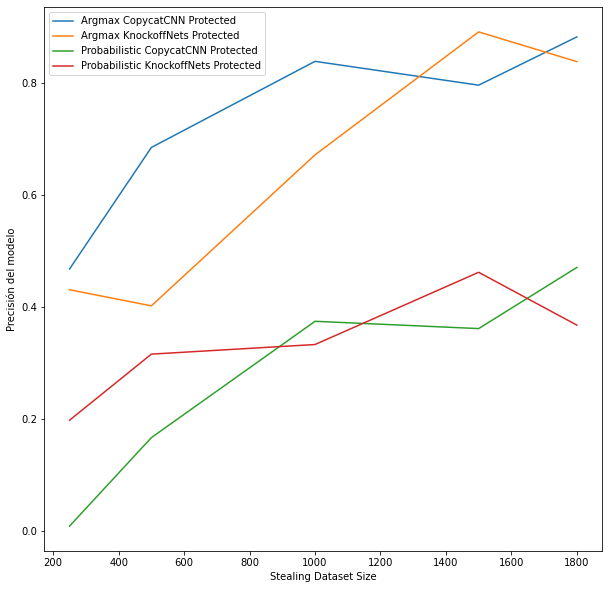

In [87]:
df_protected = pd.DataFrame(
    resultsPr, 
    columns=('Method Name', 
             'Stealing Dataset Size', 
             'Accuracy'))

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("Tamaño")
ax.set_ylabel("Precisión del modelo")
for name, group in df_protected.groupby("Method Name"):group.plot(1, 2, ax=ax, label=name)
plt.show()

